In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GroupKFold, GroupShuffleSplit
from sklearn.metrics import *
import gc
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML

In [2]:
# Lets import our data
target = pd.read_csv('target.csv')
data = pd.read_csv('data.csv')
test = pd.read_csv('test.csv')
vdata = pd.read_csv('vdata.csv')
vtarget = pd.read_csv('vtarget.csv')
ltarget = pd.read_csv('ltarget.csv', header=None)
lvtarget = pd.read_csv('lvtarget.csv', header=None)
wdata = pd.read_csv('whole_data.csv')
wtarget = pd.read_csv('whole_target.csv', header=None)

winedata = pd.read_csv('winedata.csv')

ccdata = pd.read_csv('creditcard.csv')

irisdata = pd.read_csv('irisdata.csv')
iristarget = pd.read_csv('iristarget.csv')

print('Data is ready!')

Data is ready!


In [3]:
# Because XGBoost uses a .split() command we will get rid of any whitespace in our column names.
winedata.columns = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol', 'quality']
irisdata.columns = ['sepal_length_(cm)','sepal_width_(cm)','petal_length_(cm)','petal_width_(cm)']

In [4]:
# Lets go ahead and set up our data. First lets make our target and drop it from wine.
winetarget = winedata['quality']
winedata = winedata.drop('quality', axis=1)

# Lets trim off time and amount from ccdata as those are independent features we don't want the model to learn.
cctarget = ccdata['Class']
ccdata = ccdata.drop(['Time','Amount', 'Class'], axis=1)

iristarget = iristarget['target']

target = target['surface']
vtarget = vtarget['surface']
ltarget = ltarget[0]
lvtarget = lvtarget[0]
wdata = wdata.drop(['series_id', 'group_id', 'surface'], axis=1)
wtarget = wtarget[0]

irisd, id_test, irist, it_test = train_test_split(irisdata, iristarget, test_size=0.33, random_state=42)
wined, wd_test, winet, wt_test = train_test_split(winedata, winetarget, test_size=0.33, random_state=42)
ccd, ccd_test, cct, cct_test = train_test_split(ccdata, cctarget, test_size=0.33, random_state=42)

In [5]:
# Now lets make sure our train and target variables are even for every dataset
print(irisdata.shape)
print(iristarget.shape)

print(winedata.shape)
print(winetarget.shape)

print(ccdata.shape)
print(cctarget.shape)

print(target.shape)
print(vtarget.shape)
print(ltarget.shape)
print(lvtarget.shape)
print(wtarget.shape)
print(wdata.shape)
print(vdata.shape)
print(data.shape)
test.shape

(150, 4)
(150,)
(6497, 11)
(6497,)
(284807, 28)
(284807,)
(2804,)
(1006,)
(358912,)
(128768,)
(487680,)
(487680, 23)
(128768, 23)
(358912, 23)


(488448, 23)

In [6]:
# Just like in our other notebooks we are going to SMOTE the ccdata
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=0.5, random_state=2)

ccd_SMOTE, cct_SMOTE = sm.fit_resample(ccd,cct)

ccd_SMOTE = pd.DataFrame(ccd_SMOTE, columns=ccd.columns)

In [7]:
# Lets see how many new minority samples there are.
print(len(cct))
len(cct_SMOTE)

190820


285715

In this notebook we will try both LightGBM and XGBoost. If you are new to machine learning and did not read my 'Standard SKLearn' notebook I would encourage you to do so. It covers more of the basics and has some great learning resources!

XGBoost is a boosting machine, The love child of kagglers everywhere! It is an incredibly powerful algorithm for learning just about anything. It is easy to set up and run but tuning is a nightmare! It has a strong learning curve but it is very worth the effort to learn. I linked an article below about how to tune XGBoost, Give it a read!

LightGBM is gradient boosting machine. You might ask what is the difference? Good question! One is much, much faster on big data. They both are awful to tune though. Again I linked the tuning guides below!

Here is a great article about the differences and the history of the two models.

https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

Below are the docs for both as well as some introductionary tutorials.

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

https://xgboost.readthedocs.io/en/latest/

https://www.kaggle.com/pintu161/implementation-of-lightgbm-for-begineers

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://xgboost.readthedocs.io/en/latest/tutorials/model.html

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [8]:
# Lets time our models for fun.
from datetime import datetime 
# Put this above the code.
start = datetime.now()

# Put this below.
stop = datetime.now()
execution_time = stop-start
execution_time

datetime.timedelta(0)

We will start with LightGBM. This is a great tool for large databases.

Lets start things off with the same order we used in SKLearn. Iris, Wine, CCD, IMUSD.

We are going to do both regular Cross-Validation and fixed set validation.

In [14]:
# This will be a fixed set validation model. The next model will use CV.

# For keeping time
start = datetime.now()
# Loading our data as a custom LGM dataset.
train_data=lgb.Dataset(irisd,label=irist)

# Our model's parameters.
param = {'objective':"multiclass", 'metric':["multi_logloss",'auc'], 'num_class':3}
# param['metric'] = ['auc', 'multi_logloss']

# The amount of trees we will explore.
num_round=50

# The training command and testing
lgbm=lgb.train(param,train_data,num_round)
y_pred=lgbm.predict(id_test)

# This tells us how well our model is doing.
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(it_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

stop = datetime.now()
execution_time = stop-start
print(execution_time)
# datetime.timedelta( , , ) representation => (days , seconds , microseconds)

LightGBMError: Multiclass objective and metrics don't match

In [18]:
# This is our first CV model, I'll keep the formatting of both for future models.

start = datetime.now()
# The number of CV folds we want to do.
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

# These are our model's hyperparameters which we will tune by hand to give us the best model we get get!
params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'binary',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }

# Our data, this time not as a custom dataset.
X = data
Y = ltarget

# Our model
model = lgb.LGBMClassifier(**params, n_estimators = 20, n_jobs = -1)

# This trains our model then tells us how well it is doing.
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Accuracy: 96.17%
0:00:08.679766


In [ ]:

start = datetime.now()

train_data=lgb.Dataset(ccd,label=cct)

param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

num_round=50

lgbm=lgb.train(param,train_data,num_round)
y_pred=lgbm.predict(ccd_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(cct_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'binary',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }

X = data
Y = ltarget

model = lgb.LGBMClassifier(**params, n_estimators = 20, n_jobs = -1)

results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

train_data=lgb.Dataset(ccd,label=cct)

param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

num_round=50

lgbm=lgb.train(param,train_data,num_round)
y_pred=lgbm.predict(ccd_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(cct_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'binary',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }

X = data
Y = ltarget

model = lgb.LGBMClassifier(**params, n_estimators = 20, n_jobs = -1)

results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

train_data=lgb.Dataset(ccd,label=cct)

param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

num_round=50

lgbm=lgb.train(param,train_data,num_round)
y_pred=lgbm.predict(ccd_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(cct_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'binary',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }

X = data
Y = ltarget

model = lgb.LGBMClassifier(**params, n_estimators = 20, n_jobs = -1)

results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Awesome!

XGBoost Time!

We will do the same order and tests as above with similar hyperparameters to see how each algorithm compares.

[0]	train-merror:0.04	valid_data-merror:0
Multiple eval metrics have been passed: 'valid_data-merror' will be used for early stopping.

Will train until valid_data-merror hasn't improved in 200 rounds.
Stopping. Best iteration:
[0]	train-merror:0.04	valid_data-merror:0

Accuracy: 100.00%


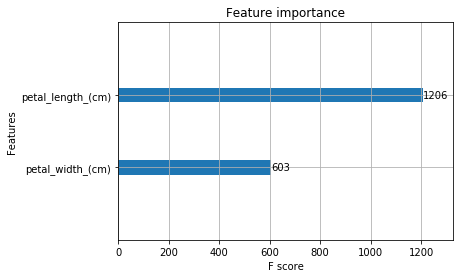

In [14]:
start = datetime.now()

# These are the list of parameters for the model. Reference the param guide at the start of the notebook for changing them.
param = {'max_depth':100, 'eta':.001, 'silent':1, 'objective':'multi:softmax', 'num_class':3, 'nthread':-1}

# These create custom matrices for the model to work with.
train_data = xgb.DMatrix(data=irisd, label=irist)
valid_data = xgb.DMatrix(data=id_test, label=it_test)

# You add the matrices above into a list. The model uses to train and evaluate itself.
watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
# This is the main model we will use for XGBoost, The set up below this code block is for a CV model.
model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
# This is what we use to test the model's performance.
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(it_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# We can even plot how important each feature is to the model!
xgb.plot_importance(model)

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [15]:
start = datetime.now()

# We will not use DMatrix for the CV model. Instead load the data as such
X = irisdata
Y = iristarget

# CV model, The params are given below instead of in a seperate dict.
model = xgb.XGBClassifier(max_depth=100, n_estimators=0, learning_rate=0.01, objective='multi:softmax', num_class=3, n_jobs=-1)
# You can change the KFolds but the standards are 3, 5, or 10. In this case 3 works best.
kfold = StratifiedKFold(n_splits=3, random_state=7)
# This is our accuracy metric.
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Accuracy: 33.33%


Now then if you are comming from the SKLearn notebook you know of my struggle with the wine dataset! Lets see if we can conquer it once and for all!!! 

In [ ]:
start = datetime.now()

param = {'max_depth':100, 'eta':.001, 'silent':1, 'objective':'binary:logistic', 'num_class':1, 'nthread':-1}

train_data = xgb.DMatrix(data=wined, label=winet)
valid_data = xgb.DMatrix(data=wd_test, label=wt_test)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(wt_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

xgb.plot_importance(model)

stop = datetime.now()
execution_time = stop-start
print(execution_time)

YES! Lets see how the model does with CV.

In [ ]:
start = datetime.now()

# load data
X = winedata
Y = winetarget

# CV model
model = xgb.XGBClassifier(max_depth=100, n_estimators=0, learning_rate=0.01, objective='binary:logistic', n_jobs=-1)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Not that good huh? If you can't tell I'm not a huge fan of CV

Ah well, Onto CCD!

In [ ]:
start = datetime.now()

param = {'max_depth':1, 'eta':.001, 'silent':1, 'objective':'binary:logistic', 'num_class':1, 'nthread':-1}

train_data = xgb.DMatrix(data=ccd, label=cct)
valid_data = xgb.DMatrix(data=ccd_test, label=cct_test)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain=train_data, num_boost_round=20, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(cct_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

xgb.plot_importance(model)

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

# load data
X = ccdata
Y = cctarget

# CV model
model = xgb.XGBClassifier(max_depth=1, n_estimators=0, learning_rate=0.001, objective='binary:logistic', n_jobs=-1)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

# Lets also do the SMOTE data to see the difference.
param = {'max_depth':1, 'eta':.001, 'silent':1, 'objective':'binary:logistic', 'num_class':1, 'nthread':-1}

train_data = xgb.DMatrix(data=ccd_SMOTE, label=cct_SMOTE)
valid_data = xgb.DMatrix(data=ccd_test, label=cct_test)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain=train_data, num_boost_round=20, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(cct_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

xgb.plot_importance(model)

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Interesting, So there are some big differences between SMOTE, non-SMOTE and CV methods!

Lets see how our IMUSD does with XGBoost.

In [ ]:
start = datetime.now()

param = {'max_depth':1, 'eta':.001, 'silent':1, 'objective':'multi:softmax', 'num_class':9, 'nthread':-1}

train_data = xgb.DMatrix(data=data, label=ltarget)
valid_data = xgb.DMatrix(data=vdata, label=lvtarget)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain=train_data, num_boost_round=20, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(lvtarget, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

xgb.plot_importance(model)

stop = datetime.now()
execution_time = stop-start
print(execution_time)

In [ ]:
start = datetime.now()

# load data
X = wdata
Y = wtarget

# CV model
model = xgb.XGBClassifier(max_depth=1, n_estimators=0, learning_rate=0.001, objective='multi:softmax', num_class=9, n_jobs=-1)
kfold = StratifiedKFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

stop = datetime.now()
execution_time = stop-start
print(execution_time)

Wow we see comparable results with our deep model. Not near the actual best but still good. We can see the large difference between RandomForest and regular trees and Boosted trees

Thats it for this notebook! Thanks for reading, If you haven't already check out the other notebooks :)